In [1]:
!pip install -q tensorflow_datasets==4.4.0
!pip install -q tensorflow==2.4.1
import tensorflow_datasets as tfds
import tensorflow as tf

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.4.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.4.1 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.4.1 which is incompatible.
tensorflow-io 0

2022-08-10 13:30:18.364147: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
(train,test,val), ds_info = tfds.load(
    'patch:1.0.0',
    split=['train', 'test', 'val'],
    with_info=True,
    data_dir='../input/patchtfds'
)

2022-08-10 13:30:24.992249: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-10 13:30:24.993893: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-10 13:30:25.080685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 13:30:25.084670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-08-10 13:30:25.084724: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-08-10 13:30:25.124679: I tensorflow/stream_executor/platform/def

In [4]:
def get_img(sample):
    label = sample['label']
    image = sample['image']
    return image,label

ds = train.map(get_img)
ds_val = val.map(get_img)
ds_test = test.map(get_img).batch(8,drop_remainder=True)

2022-08-10 13:30:26.409856: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-10 13:30:26.411229: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


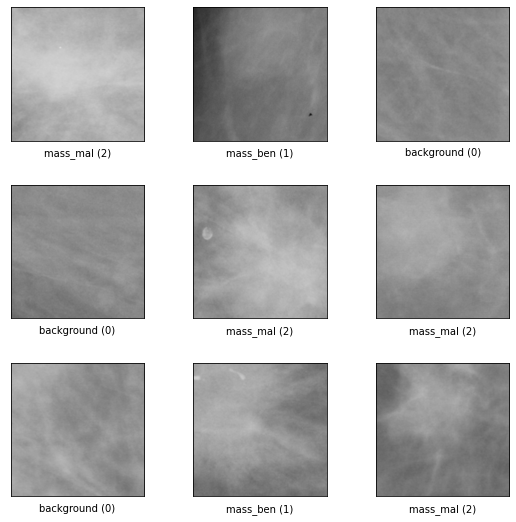

In [5]:
fig = tfds.show_examples(ds, ds_info)

In [6]:
def cf_matrix(model,dataset):
    y_pred = model.predict(dataset)
    y_pred = np.argmax(y_pred, axis=-1)
    y_true = tf.concat([y for x, y in dataset], axis=0).numpy()
    res = confusion_matrix(y_true = list(y_true),
                           y_pred = y_pred,
                           normalize = 'true'
                           )
    target_names = ["Background",
                    "Benign_mass",
                    "Malignant_mass"]
    res = pd.DataFrame(res,index = target_names,columns = target_names)

    fig, ax = plt.subplots(figsize=(6,5))
    heatmap = sns.heatmap(res, annot=True, ax = ax,linewidths = 0.01)#square=True)# 
    ax.set_ylabel('True Lables')
    ax.set_xlabel('Predict Lables')
    plt.xticks(rotation = 45,ha='right', rotation_mode='anchor')
    plt.show()

2022-08-10 13:30:30.478343: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-08-10 13:30:31.523393: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-08-10 13:30:31.527382: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


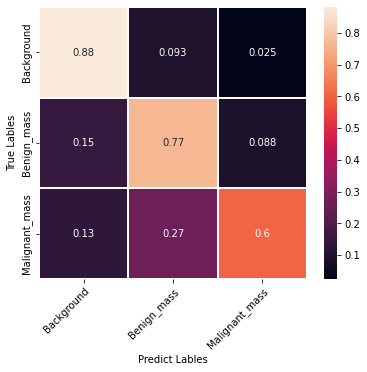

In [7]:
model = tf.keras.models.load_model('../input/model-save/repo/vgg16.h5')
cf_matrix(model,ds_test)

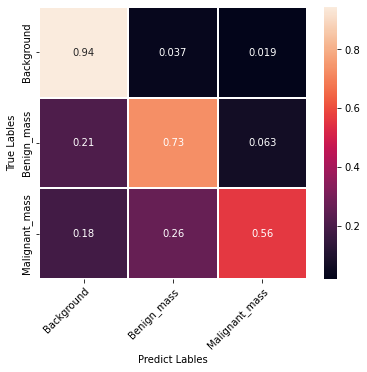

In [8]:
model = tf.keras.models.load_model('../input/model-save/repo/resnet50.h5')
cf_matrix(model,ds_test)